Import stuff
------------

In [1]:
import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

# Change this with the directory where you cloned the imgdetect-utils repo
basedir = os.path.join(os.path.expanduser('~'), 'Downloads/uv_cleaner/human_detection')
sys.path.append(os.path.join(basedir))
sys.path.append(os.path.join(basedir, 'imgdetect-utils'))

from src.image_helpers import plot_images_grid, create_dataset_files
from src.train_helpers import load_data, plot_results, export_model

# The Tensorflow model and properties file will be stored here
tf_model_dir = os.path.join(basedir, 'models', 'tensorflow')
tf_model_file = os.path.join(tf_model_dir, 'saved_model.pb')
tf_properties_file = os.path.join(tf_model_dir, 'saved_model.json')

# Base directory that contains your training images and dataset files
dataset_base_dir = os.path.join(basedir, 'datasets')
dataset_dir = os.path.join(dataset_base_dir, 'data')

# Store your thermal camera images here
img_dir = os.path.join(dataset_base_dir, 'images')

# Size of the input images
input_size = (24, 32)

Create a dataset files from the available images
------------------------------------------------

In [2]:
dataset_files = create_dataset_files(img_dir, dataset_dir,
                                     split_size=500,
                                     num_threads=1,
                                     resize=input_size,
                                     color_convert='COLOR_BGR2GRAY')
dataset_files

Processing 301 images to 1 dataset files. Format: /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset{:01}.npz
Storing dataset vectors to /Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset0.npz


['/Users/hyungjaekim/Downloads/uv_cleaner/human_detection/datasets/data/dataset0.npz']

Get the training and test set randomly out of the dataset with a split of 70/30
-------------------------------------------------------------------------------

In [3]:
train_set, test_set, classes = load_data(*dataset_files, split_percentage=0.8)
print('Loaded {} training images and {} test images. Classes: {}'.format(
    train_set.shape[0], test_set.shape[0], classes))

Loaded 241 training images and 60 test images. Classes: ['negative' 'positive']


/Users/hyungjaekim/opt/anaconda3/envs/uv_cleaner/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [4]:
train_images = np.asarray([item[0] for item in train_set])
train_labels = np.asarray([item[1] for item in train_set])
test_images = np.asarray([item[0] for item in test_set])
test_labels = np.asarray([item[1] for item in test_set])

Inspect the first 25 images in the training set
-----------------------------------------------


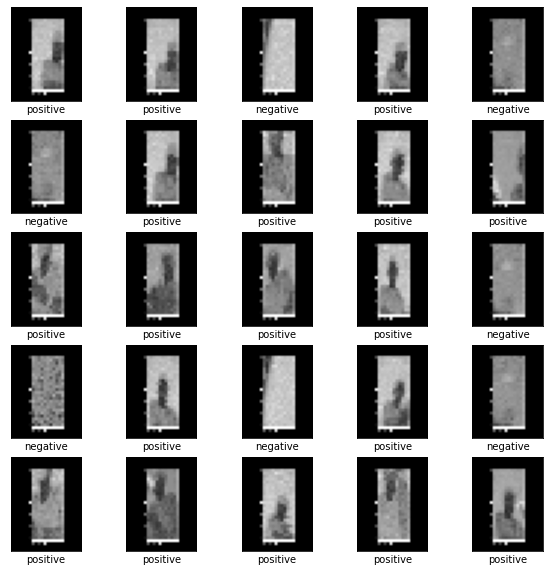

In [5]:
plot_images_grid(images=train_images, labels=train_labels, classes=classes, rows=5, cols=5)


Declare the model
-----------------

* Flatten input
* Layer 1: 60% the number of pixels per image
* Layer 2: 30% the number of pixels per image
* Layer 3: as many neurons as the output labels (in this case 2: negative, positive)

In [6]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape),
    keras.layers.Dense(int(0.6 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(int(0.3 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

2021-08-18 00:13:53.922935: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-18 00:13:53.936159: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc599657270 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-18 00:13:53.936173: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Compile the model
-----------------

- *Loss function*:This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer*: This is how the model is updated based on the data it sees and its loss function.
- *Metrics*: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model
---------------

In [9]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

val_images = train_images[:180]
partial_images = train_images[180:]
val_labels = train_labels[:180]
partial_labels = train_labels[180:]

history = model.fit(partial_images, partial_labels, epochs = 20, 
                    validation_data=(val_images, val_labels), callbacks=[earlystopping])

#model.fit(train_images, train_labels, epochs=100)

Epoch 1/20
2/2 [==============================] - 0s 35ms/step - loss: 0.6610 - accuracy: 0.6557 - val_loss: 0.5424 - val_accuracy: 0.7500
Epoch 2/20
2/2 [==============================] - 0s 32ms/step - loss: 0.6439 - accuracy: 0.6557 - val_loss: 0.5448 - val_accuracy: 0.7500
Epoch 3/20
2/2 [==============================] - 0s 29ms/step - loss: 0.6114 - accuracy: 0.6557 - val_loss: 0.6342 - val_accuracy: 0.8778
Epoch 4/20
2/2 [==============================] - 0s 33ms/step - loss: 0.6362 - accuracy: 0.8689 - val_loss: 0.5789 - val_accuracy: 0.7500
Epoch 5/20
2/2 [==============================] - 0s 29ms/step - loss: 0.5871 - accuracy: 0.6557 - val_loss: 0.5151 - val_accuracy: 0.7500
Epoch 6/20
2/2 [==============================] - 0s 25ms/step - loss: 0.6111 - accuracy: 0.6557 - val_loss: 0.5097 - val_accuracy: 0.7500
Epoch 7/20
2/2 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.71 - 0s 37ms/step - loss: 0.6043 - accuracy: 0.6557 - val_loss: 0.5120 - val_ac

Evaluate accuracy against the test set
--------------------------------------

In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 2ms/step - loss: 0.4361 - accuracy: 0.9667
Test accuracy: 0.9666666388511658


Make predictions on the test set
--------------------------------

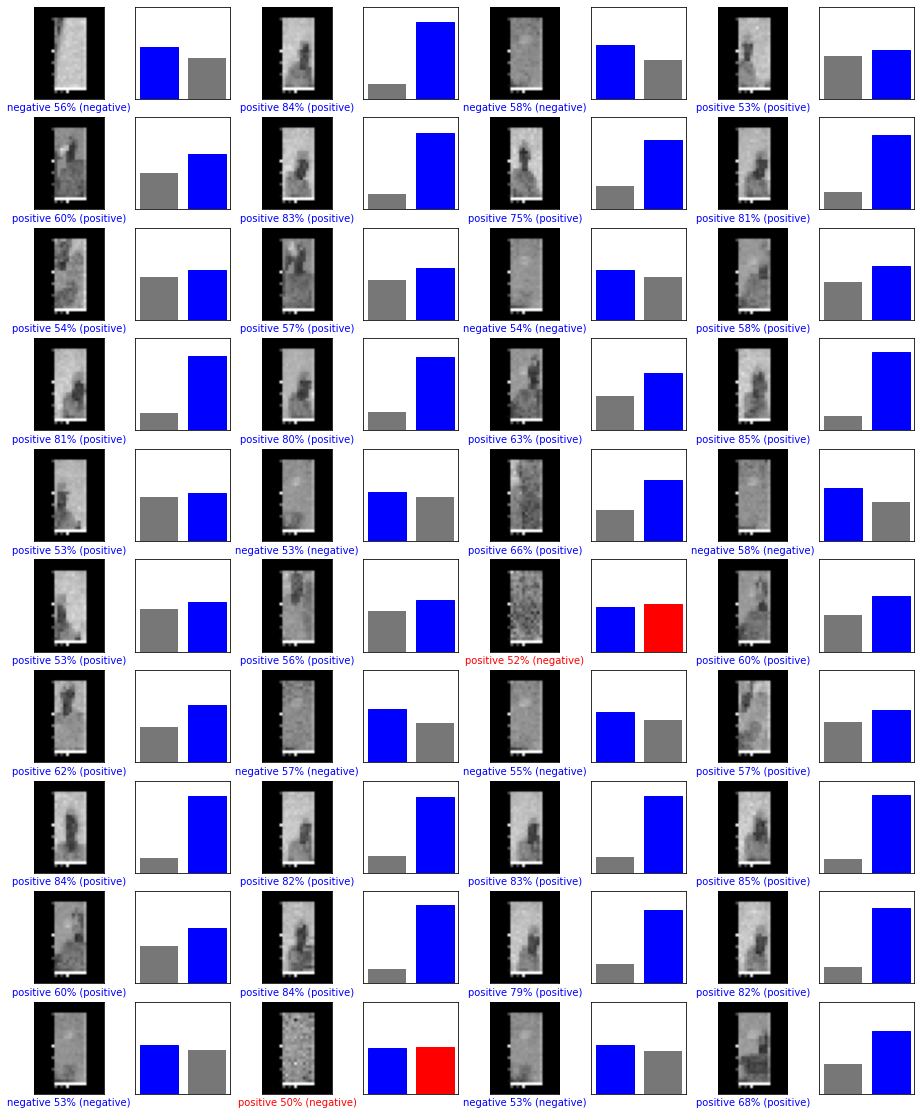

In [12]:
predictions = model.predict(test_images)
plot_results(images=test_images, labels=test_labels, classes=classes, predictions=predictions, rows=10, cols=4)

Export as a Tensorflow model
----------------------------

In [ ]:
"""
export_model(model, tf_model_file,
             properties_file=tf_properties_file,
             classes=classes,
             input_size=(32, 34, 3))
"""

def model_save(model, target, labels=None, overwrite=True):
    import json
    import pathlib

    # Check if we should save it like a .h5/.pb file or as a directory
    model_dir = pathlib.Path(target)
    if str(target).endswith('.h5') or str(target).endswith('.pb'):
        model_dir = model_dir.parent

    # Create the model directory if it doesn't exist
    pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)

    # Save the Tensorflow model using the .save method
    model.save(target, overwrite=overwrite)

    # Save the label names of your model in a separate JSON file
    if labels:
        labels_file = os.path.join(model_dir, 'labels.json')
        with open(labels_file, 'w') as f:
            f.write(json.dumps(list(labels)))
            
labels = {'negative':0, 'positive':1}
labels.keys()

model_dir = os.path.expanduser('~/Downloads/uv_cleaner/human_detection/models')
model_save(model, model_dir, labels=labels, overwrite=True)

In [13]:
import glob
import numpy as np
from PIL import Image
import cv2
import datetime

txt_file_names = list(glob.glob("~/Downloads/uv_cleaner/human_detection/datasets/"))
img_list = []
cnt = 0
for file_name in txt_file_names:
    cnt += 1
    line_list = []
    with open(file_name) as f:
        lines = f.readlines()
        for line in lines:
            sub_line = line.split(',')
            sub_line[-1] = sub_line[-1][:-1]
            line_list.append(sub_line)
        np_arr = np.array(line_list).astype('float32')
        np_arr = (((np_arr - np_arr.min()) / (np_arr.max() - np_arr.min())) * 255.9).astype(np.uint8)
        img = Image.fromarray(np_arr)
        img.save(f"D:\\~\\datasets\\new_people_detect\\txt_images\\negative\\{cnt}.png")

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.        ]
 [1.